In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt
from collections import Counter, OrderedDict

In [2]:
covid = pd.read_csv("Covid-19 Activity.csv")
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639710 entries, 0 to 639709
Data columns (total 13 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   COUNTY_NAME                      595792 non-null  object 
 1   PEOPLE_POSITIVE_CASES_COUNT      639710 non-null  float64
 2   REPORT_DATE                      639710 non-null  object 
 3   PROVINCE_STATE_NAME              597892 non-null  object 
 4   CONTINENT_NAME                   639710 non-null  object 
 5   DATA_SOURCE_NAME                 639710 non-null  object 
 6   PEOPLE_DEATH_NEW_COUNT           639710 non-null  float64
 7   COUNTY_FIPS_NUMBER               585672 non-null  float64
 8   COUNTRY_ALPHA_3_CODE             639710 non-null  object 
 9   COUNTRY_SHORT_NAME               639710 non-null  object 
 10  COUNTRY_ALPHA_2_CODE             639504 non-null  object 
 11  PEOPLE_POSITIVE_NEW_CASES_COUNT  639710 non-null  float64
 12  PE

In [3]:
covid.head()

,COUNTY_NAME,PEOPLE_POSITIVE_CASES_COUNT,REPORT_DATE,PROVINCE_STATE_NAME,CONTINENT_NAME,DATA_SOURCE_NAME,PEOPLE_DEATH_NEW_COUNT,COUNTY_FIPS_NUMBER,COUNTRY_ALPHA_3_CODE,COUNTRY_SHORT_NAME,COUNTRY_ALPHA_2_CODE,PEOPLE_POSITIVE_NEW_CASES_COUNT,PEOPLE_DEATH_COUNT
0,Wahkiakum,0.0,2020-02-18,Washington,America,New York Times,0.0,53069.0,USA,United States,US,0.0,0.0
1,Wahkiakum,5.0,2020-07-17,Washington,America,New York Times,0.0,53069.0,USA,United States,US,0.0,0.0
2,Wahkiakum,0.0,2020-03-02,Washington,America,New York Times,0.0,53069.0,USA,United States,US,0.0,0.0
3,Stephenson,223.0,2020-06-11,Illinois,America,New York Times,0.0,17177.0,USA,United States,US,1.0,5.0
4,Stephenson,1.0,2020-03-22,Illinois,America,New York Times,0.0,17177.0,USA,United States,US,1.0,0.0


In [4]:
covid.isnull().sum()

COUNTY_NAME                        43918
PEOPLE_POSITIVE_CASES_COUNT            0
REPORT_DATE                            0
PROVINCE_STATE_NAME                41818
CONTINENT_NAME                         0
DATA_SOURCE_NAME                       0
PEOPLE_DEATH_NEW_COUNT                 0
COUNTY_FIPS_NUMBER                 54038
COUNTRY_ALPHA_3_CODE                   0
COUNTRY_SHORT_NAME                     0
COUNTRY_ALPHA_2_CODE                 206
PEOPLE_POSITIVE_NEW_CASES_COUNT        0
PEOPLE_DEATH_COUNT                     0
dtype: int64

In [5]:
# dropping columns that aren't too useful for this analysis
covid.drop(columns=['COUNTRY_ALPHA_2_CODE', 'COUNTY_FIPS_NUMBER', 'COUNTY_NAME'], inplace=True)
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639710 entries, 0 to 639709
Data columns (total 10 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   PEOPLE_POSITIVE_CASES_COUNT      639710 non-null  float64
 1   REPORT_DATE                      639710 non-null  object 
 2   PROVINCE_STATE_NAME              597892 non-null  object 
 3   CONTINENT_NAME                   639710 non-null  object 
 4   DATA_SOURCE_NAME                 639710 non-null  object 
 5   PEOPLE_DEATH_NEW_COUNT           639710 non-null  float64
 6   COUNTRY_ALPHA_3_CODE             639710 non-null  object 
 7   COUNTRY_SHORT_NAME               639710 non-null  object 
 8   PEOPLE_POSITIVE_NEW_CASES_COUNT  639710 non-null  float64
 9   PEOPLE_DEATH_COUNT               639710 non-null  float64
dtypes: float64(4), object(6)
memory usage: 48.8+ MB


In [6]:
# since a count of people will always be a whole number, change floats to ints
covid['PEOPLE_POSITIVE_CASES_COUNT'] = covid['PEOPLE_POSITIVE_CASES_COUNT'].astype(int)
covid['PEOPLE_DEATH_NEW_COUNT'] = covid['PEOPLE_DEATH_NEW_COUNT'].astype(int)
covid['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = covid['PEOPLE_POSITIVE_NEW_CASES_COUNT'].astype(int)
covid['PEOPLE_DEATH_COUNT'] = covid['PEOPLE_DEATH_COUNT'].astype(int)

# filter the rows that hold no information for country name, positive cases, and death counts
no_stats = covid.loc[(covid['PROVINCE_STATE_NAME'].isnull()) & (covid['PEOPLE_POSITIVE_CASES_COUNT'] == 0) &
         (covid['PEOPLE_DEATH_NEW_COUNT'] == 0) & (covid['PEOPLE_POSITIVE_NEW_CASES_COUNT'] == 0)
         & (covid['PEOPLE_DEATH_COUNT'] == 0)]

# drop those filtered rows and get rid of duplicates
covid.drop(list(no_stats.index), inplace=True)
covid.drop_duplicates(inplace=True)

# for the rest, replace with 'unknown' since they hold stats
covid.fillna('Unknown', inplace=True)
covid.isnull().sum()

PEOPLE_POSITIVE_CASES_COUNT        0
REPORT_DATE                        0
PROVINCE_STATE_NAME                0
CONTINENT_NAME                     0
DATA_SOURCE_NAME                   0
PEOPLE_DEATH_NEW_COUNT             0
COUNTRY_ALPHA_3_CODE               0
COUNTRY_SHORT_NAME                 0
PEOPLE_POSITIVE_NEW_CASES_COUNT    0
PEOPLE_DEATH_COUNT                 0
dtype: int64

In [7]:
def provincial_case(df, country):
    '''
    Args:
        df: DataFrame
        country: str
    Returns:
        a list of *confirmed* cases of Covid-19 for each province in the country
    Order:
        Descending
    '''
    country_table = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    province_list = country_table['PROVINCE_STATE_NAME'].unique()
    province_dict = dict()
    for province in province_list:
        province_dict[province] = country_table.loc[country_table['PROVINCE_STATE_NAME'] == province]['PEOPLE_POSITIVE_CASES_COUNT'].max()
    return sorted(province_dict.items(), key=lambda x: x[1], reverse=True)


def country_case(df, country):
    '''
    Args:
        df: DataFrame
        country: str
    Returns:
        a sum of *confirmed* cases of Covid-19 in a country
    '''
    province_list = df.loc[df['COUNTRY_SHORT_NAME'] == country]['PROVINCE_STATE_NAME'].unique()
    total = 0
    for province in province_list:
        total += df.loc[df['PROVINCE_STATE_NAME'] == province]['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum()
    return (country, total)

print(provincial_case(covid, 'Canada'))
print(country_case(covid, 'Canada'))

[('Quebec', 57938), ('Ontario', 38107), ('Alberta', 9861), ('British Columbia', 3362), ('Nova Scotia', 1067), ('Saskatchewan', 1030), ('Manitoba', 361), ('Newfoundland and Labrador', 264), ('New Brunswick', 170), ('Prince Edward Island', 36), ('Repatriated travellers', 13), ('Yukon', 13), ('Northwest Territories', 5), ('Nunavut', 0)]
('Canada', 112402)


Now that the functions are ready, let's sort countries from the most cases to the least in America

In [8]:
america = covid.loc[covid['CONTINENT_NAME'] == 'America']['COUNTRY_SHORT_NAME'].unique()
america_list = []
for country in america:
    america_list.append(country_case(covid, country))
print(sorted(america_list, key=lambda x:x[1], reverse=True))

[('Uruguay', 11103968), ('Saint Vincent and the Grenadines', 11103968), ('Barbados', 11103968), ('Paraguay', 11103968), ('Bonaire, Saint Eustatius and Saba', 11103968), ('Costa Rica', 11103968), ('Ecuador', 11103968), ('Panama', 11103968), ('El Salvador', 11103968), ('Suriname', 11103968), ('Dominica', 11103968), ('Aruba', 11103968), ('Cayman Islands', 11103968), ('Honduras', 11103968), ('Saint Lucia', 11103968), ('Bahamas', 11103968), ('Grenada', 11103968), ('Trinidad and Tobago', 11103968), ('Haiti', 11103968), ('Turks and Caicos islands', 11103968), ('Cuba', 11103968), ('Antigua and Barbuda', 11103968), ('Venezuela', 11103968), ('Nicaragua', 11103968), ('Sint Maarten', 11103968), ('Belize', 11103968), ('Argentina', 11103968), ('Bolivia', 11103968), ('Chile', 11103968), ('Mexico', 11103968), ('Guatemala', 11103968), ('Colombia', 11103968), ('Dominican Republic', 11103968), ('Guyana', 11103968), ('Bermuda', 11103968), ('Greenland', 11103968), ('Anguilla', 11103968), ('Brazil', 1110396

### Debugging
Almost every country in America got the value of **11103968**

Let's see what's happening.

In [9]:
def country_case(df, country):
    province_list = df.loc[df['COUNTRY_SHORT_NAME'] == country]['PROVINCE_STATE_NAME'].unique()
    print(province_list)

# checking if there's anything in the province column that's causing the problem
print(country_case(covid, 'Uruguay'))
print(country_case(covid, 'Barbados'))
print(country_case(covid, 'Paraguay'))

['Unknown']
None
['Unknown']
None
['Unknown']
None


Found the problem!

The code is summing up cases of all 'Unknown' provinces from all over the world.

To limit the search to within a country, I need to use a temporary dataframe.

In [10]:
def country_case(df, country):
    '''
    Args:
        df: DataFrame
        country: str
    Returns:
        a sum of *confirmed* cases of Covid-19 in a country
    '''
    country_df = df.loc[df['COUNTRY_SHORT_NAME'] == country]
    province_list = country_df['PROVINCE_STATE_NAME'].unique()
    total = 0
    for province in province_list:
        total += country_df.loc[country_df['PROVINCE_STATE_NAME'] == province]['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum()
    return (country, total)

america = covid.loc[covid['CONTINENT_NAME'] == 'America']['COUNTRY_SHORT_NAME'].unique()
america_list = []
for country in america:
    america_list.append(country_case(covid, country))
countries_continent = sorted(america_list, key=lambda x:x[1], reverse=True)
print(countries_continent)

[('United States', 3973286), ('Brazil', 2227514), ('Peru', 366550), ('Mexico', 362274), ('Chile', 336402), ('Colombia', 218428), ('Argentina', 136105), ('Canada', 112402), ('Ecuador', 77257), ('Bolivia', 64135), ('Dominican Republic', 56043), ('Panama', 55906), ('Guatemala', 41135), ('Honduras', 36102), ('El Salvador', 12975), ('Venezuela', 12774), ('Costa Rica', 12361), ('Haiti', 7167), ('Paraguay', 4000), ('Nicaragua', 3439), ('Cuba', 2462), ('Suriname', 1176), ('Uruguay', 1117), ('Jamaica', 816), ('Guyana', 350), ('Bahamas', 219), ('Cayman Islands', 203), ('Bermuda', 153), ('Trinidad and Tobago', 141), ('Aruba', 117), ('Barbados', 106), ('Turks and Caicos islands', 86), ('Sint Maarten', 81), ('Antigua and Barbuda', 76), ('Saint Vincent and the Grenadines', 50), ('Belize', 43), ('Curaçao', 28), ('Saint Lucia', 23), ('Grenada', 23), ('Dominica', 18), ('Saint Kitts and Nevis', 17), ('Greenland', 13), ('Falkland Islands (Malvinas)', 13), ('Montserrat', 12), ('Bonaire, Saint Eustatius an

Now I got the result that's more probable.

Debugging is done.

### Investigating the progression of COVID-19 from Jan - July 2020 by continent
**Goals**
* Group data by continents and time
* Use month as the time measurement unit
* Create a newly reported cases graph

In [11]:
covid['YEAR'] = pd.to_datetime(covid['REPORT_DATE']).dt.year
covid['MONTH'] = pd.to_datetime(covid['REPORT_DATE']).dt.month
continent_new_case = covid[['CONTINENT_NAME', 'PEOPLE_POSITIVE_NEW_CASES_COUNT','YEAR', 'MONTH']].groupby(
                       ['CONTINENT_NAME','YEAR', 'MONTH'], as_index=False).sum()

In [12]:
total = 0
for item in countries_continent:
    total += item[1]
print(f'A total of cases from all countries in America: {total}')
print(f"A total of cases from time periods in America: {continent_new_case.loc[continent_new_case['CONTINENT_NAME'] == 'America']['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum()}")
print(continent_new_case)

A total of cases from all countries in America: 8123619
A total of cases from time periods in America: 8123619
   CONTINENT_NAME  YEAR  MONTH  PEOPLE_POSITIVE_NEW_CASES_COUNT
0          Africa  2020      2                                3
1          Africa  2020      3                             5134
2          Africa  2020      4                            31598
3          Africa  2020      5                           104887
4          Africa  2020      6                           251822
5          Africa  2020      7                           376503
6         America  2020      1                               11
7         America  2020      2                              116
8         America  2020      3                           211080
9         America  2020      4                          1113659
10        America  2020      5                          1541498
11        America  2020      6                          2409269
12        America  2020      7                          2

Numbers of positive cases add up correctly.

To display all this information on the same graph, let's drop Asia's Dec of 2019 and add Africa's January of 2020.

Then, I can start making graphs

### Positive Cases of each Continent

In [13]:
continent_new_case.drop(index=13, inplace=True)
continent_new_case = continent_new_case.append({'CONTINENT_NAME':'Africa', 'YEAR':2020, 'MONTH':1, 'PEOPLE_POSITIVE_NEW_CASES_COUNT':0}, ignore_index=True)
continent_new_case.sort_values(by=['CONTINENT_NAME', 'MONTH'], inplace=True)

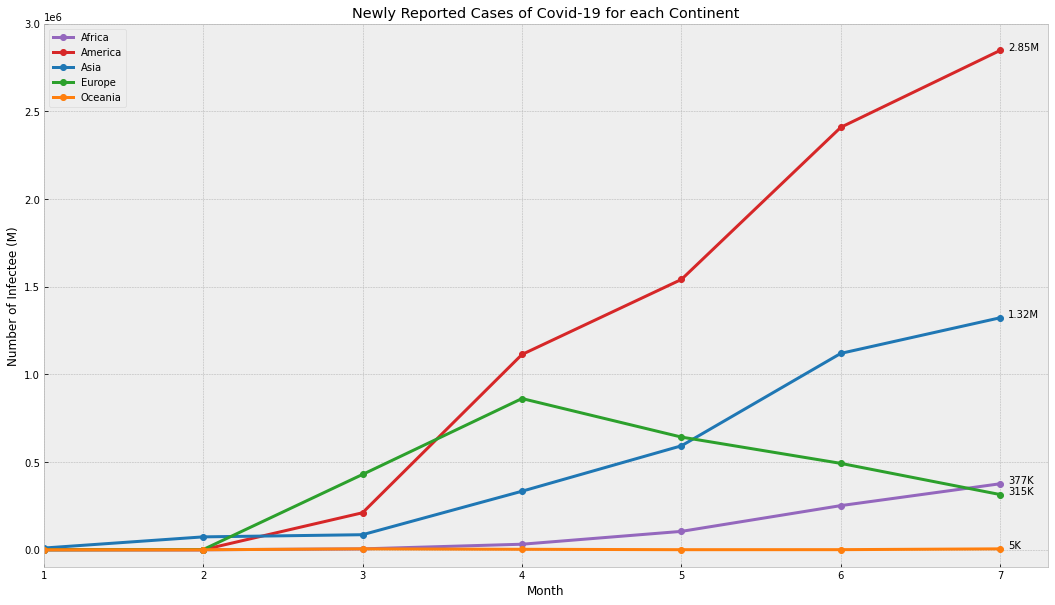

In [14]:
continent_list = continent_new_case['CONTINENT_NAME'].unique()
color_list = ['tab:purple', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange']
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [18, 10]

# use for loop to create a line graph for each continent
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent], c=color, label=continent, marker='o', linewidth=3)

# create a list of sum of cases for each continent in July (last month)
max_continent = []
for continent in continent_list:
    max_continent.append(continent_new_case.loc[(continent_new_case['CONTINENT_NAME'] == continent) & 
                                                (continent_new_case['MONTH'] == 7)]['PEOPLE_POSITIVE_NEW_CASES_COUNT'].sum())

# create and position labels
for y in max_continent:
    if y >= 1000000:
        plt.text(7.05, y, str(round(y/1000000, 2)) +'M')
    else:
        plt.text(7.05, y, str(round(y/1000)) +'K')
plt.legend()
plt.ylim(-100000, 3000000)
plt.xlim(1, 7.3)
plt.xlabel('Month')
plt.title('Newly Reported Cases of Covid-19 for each Continent')
plt.ylabel('Number of Infectee (M)')
plt.show()

To be clear each plot **doesn't** represent the sum of previous cases + new cases. It's a quantity of newly reported cases.

* Initially, Asia experienced the fastest growth rate as Wuhan is the place of origin of Covid-19
* The number in Europe spiked up in between February and April then experienced a consistent decline in growth rate
* America started slowly, then has been experiencing the fastest growth rate (it's on-going)
* Growth rates in both Africa and Oceania have been steadily and very slowly increasing

In [15]:
# create a list of total of new cases for each time period
aggregate_cases = []
total = 0
for continent in continent_list:
    for item, new_case in zip(continent_new_case['CONTINENT_NAME'], continent_new_case['PEOPLE_POSITIVE_NEW_CASES_COUNT']):
        if continent == item:
            total += new_case
            aggregate_cases.append(total)
        else:
            total = 0

# add it as a new column
continent_new_case['AGGREGATE_CASES'] = aggregate_cases

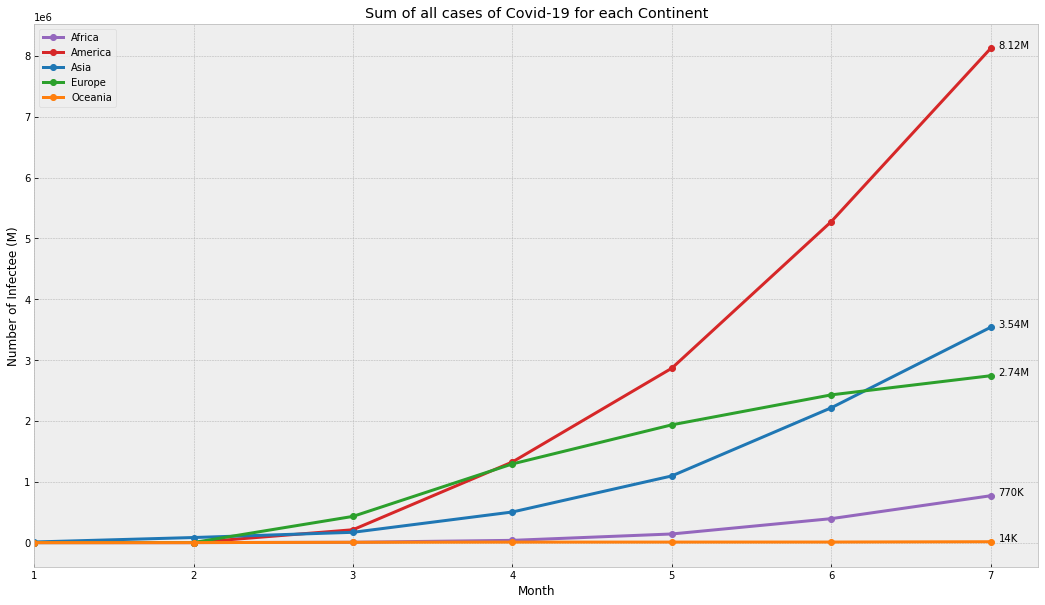

In [16]:
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH', 'AGGREGATE_CASES', data=continent_new_case.loc[continent_new_case['CONTINENT_NAME']==continent], c=color, label=continent, marker='o', linewidth=3)

max_continent = []
for continent in continent_list:
    max_continent.append(continent_new_case.loc[(continent_new_case['CONTINENT_NAME'] == continent) & 
                                                (continent_new_case['MONTH'] == 7)]['AGGREGATE_CASES'].sum())
for y in max_continent:
    if y >= 1000000:
        plt.text(7.05, y, str(round(y/1000000, 2)) +'M')
    else:
        plt.text(7.05, y, str(round(y/1000)) +'K')
plt.legend()
plt.xlabel('Month')
plt.xlim(1, 7.3)
plt.title('Sum of all cases of Covid-19 for each Continent')
plt.ylabel('Number of Infectee (M)')
plt.show()

* America is by far the *most* dangerous continent to travel in the current state - **fastest growth rate** since March
* Asia and Africa are experiencing a steady increase
* Europe and Oceania are managing to flatten the curves

### Counting Deaths of each Continent

In [17]:
continent_death = covid[['CONTINENT_NAME', 'PEOPLE_DEATH_NEW_COUNT', 'YEAR', 'MONTH']].groupby(
                       ['CONTINENT_NAME','YEAR', 'MONTH'], as_index=False).sum()
continent_death = continent_death.append({'CONTINENT_NAME':'Africa', 'YEAR':2020, 'MONTH':1, 'PEOPLE_DEATH_NEW_COUNT':0}, ignore_index=True)
continent_death.drop(index=13, inplace=True)
continent_death.sort_values(by=['CONTINENT_NAME', 'MONTH'], inplace=True)

DEATH_AGGREGATE = []
death_count = 0
for continent in continent_list:
    for item, death in zip(continent_death['CONTINENT_NAME'], continent_death['PEOPLE_DEATH_NEW_COUNT']):
        if continent == item:
            death_count += death
            DEATH_AGGREGATE.append(death_count)
        else:
            death_count = 0
continent_death['DEATH_AGGREGATE'] = DEATH_AGGREGATE
print(continent_death)

   CONTINENT_NAME  YEAR  MONTH  PEOPLE_DEATH_NEW_COUNT  DEATH_AGGREGATE
35         Africa  2020      1                       0                0
0          Africa  2020      2                       0                0
1          Africa  2020      3                     166              166
2          Africa  2020      4                    1425             1591
3          Africa  2020      5                    2480             4071
4          Africa  2020      6                    5807             9878
5          Africa  2020      7                    6552            16430
6         America  2020      1                       0                0
7         America  2020      2                       1                1
8         America  2020      3                    4804             4805
9         America  2020      4                   72049            76854
10        America  2020      5                   85196           162050
11        America  2020      6                   87647          

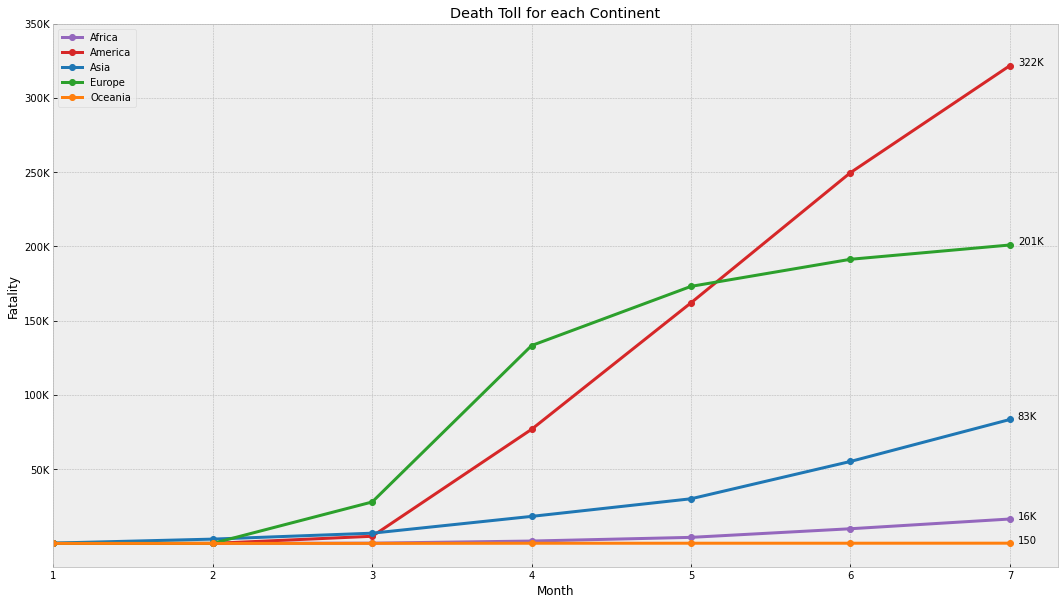

In [18]:
for continent, color in zip(continent_list, color_list):
    plt.plot('MONTH', 'DEATH_AGGREGATE', data=continent_death.loc[continent_death['CONTINENT_NAME']==continent], c=color, label=continent, marker='o', linewidth=3)

max_death = []
for continent in continent_list:
    max_death.append(continent_death.loc[(continent_death['CONTINENT_NAME'] == continent) & 
                                                (continent_death['MONTH'] == 7)]['DEATH_AGGREGATE'].sum())

for y in max_death:
    if y >= 1000:
        plt.text(7.05, y, str(round(y/1000)) +'K')
    else:
        plt.text(7.05, y, str(y))
plt.legend()
plt.xlim(1, 7.3)
plt.xlabel('Month')
plt.title('Death Toll for each Continent')
yticks = [50000, 100000, 150000, 200000, 250000, 300000, 350000]
ylabels = ['50K', '100K', '150K', '200K', '250K', '300K', '350K']
plt.yticks(ticks=yticks, labels=ylabels)
plt.ylabel('Fatality')
plt.show()

* As observed from previous graphs, the decline of Covid-19's positive cases in Europe has resulted in gentler slopes after April
* The extreme growth rate of positive cases in America is reflected by the steep slope on this graph
* Although the total of positive cases in Asia is greater than that of Europe by 80,000, death toll is much lower (it could be the consequence of how well the countries handled the situation)

### Death Rate

In [19]:
def death_rate(df, continent):
    '''
    Args:
        df: DataFrame
        header: str or a list of str, a header of a column 
    Return:
         death rate of a continent or an average death rate of continents
    '''
    # if calculating death rate of a continent, find the lastest updates of death and infected population
    if type(continent) == str:
        temp = df.loc[df['CONTINENT_NAME'] == continent]
        return '{}%'.format(round(temp['PEOPLE_DEATH_COUNT'].max()/temp['PEOPLE_POSITIVE_CASES_COUNT'].max()*100, 2))
    # if calculating death rate of continents, find each continent's death rate and find the average
    else:
        death = []
        population = []
        total = 0
        for item in continent:
            death.append(df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_DEATH_COUNT'].max())
            population.append(df.loc[df['CONTINENT_NAME'] == item]['PEOPLE_POSITIVE_CASES_COUNT'].max())
        for d, p in zip(death, population):
            total += d/p*100
        return '{}%'.format(round(total/len(death), 2))

print(death_rate(covid,'Africa'))
print(death_rate(covid,'America'))
print(death_rate(covid,['Africa', 'America']))

1.5%
3.72%
2.61%


In [20]:
total_all = covid[['MONTH', 'PEOPLE_POSITIVE_NEW_CASES_COUNT', 'PEOPLE_DEATH_NEW_COUNT']].groupby(['MONTH']).sum()
total_all.drop(12, inplace=True)
total_positive_list = []
total_death_list = []
count_positive = 0
count_death = 0
for positive, death in zip(total_all['PEOPLE_POSITIVE_NEW_CASES_COUNT'], total_all['PEOPLE_DEATH_NEW_COUNT']):
    count_positive += positive
    count_death += death
    total_positive_list.append(count_positive)
    total_death_list.append(count_death)
total_all['TOTAL_POSITIVE_CASE'] = total_positive_list
total_all['TOTAL_DEATH'] = total_death_list
print(total_all)

       PEOPLE_POSITIVE_NEW_CASES_COUNT  PEOPLE_DEATH_NEW_COUNT  \
MONTH                                                            
1                                 9801                     213   
2                                74734                    2703   
3                               736816                   36864   
4                              2344167                  190224   
5                              2882292                  139416   
6                              4274291                  136820   
7                              4867528                  116530   

       TOTAL_POSITIVE_CASE  TOTAL_DEATH  
MONTH                                    
1                     9801          213  
2                    84535         2916  
3                   821351        39780  
4                  3165518       230004  
5                  6047810       369420  
6                 10322101       506240  
7                 15189629       622770  


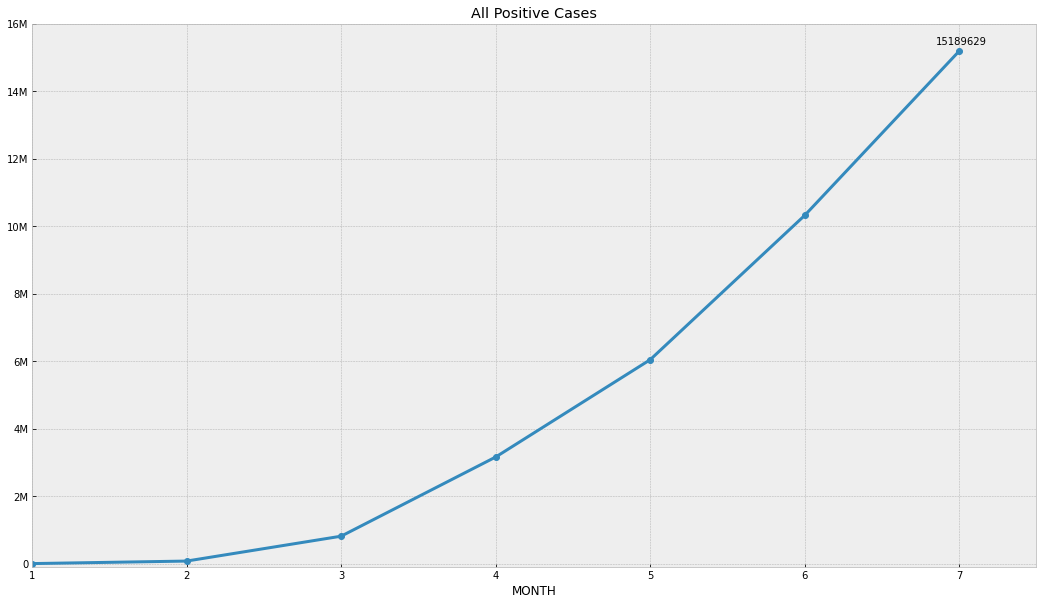

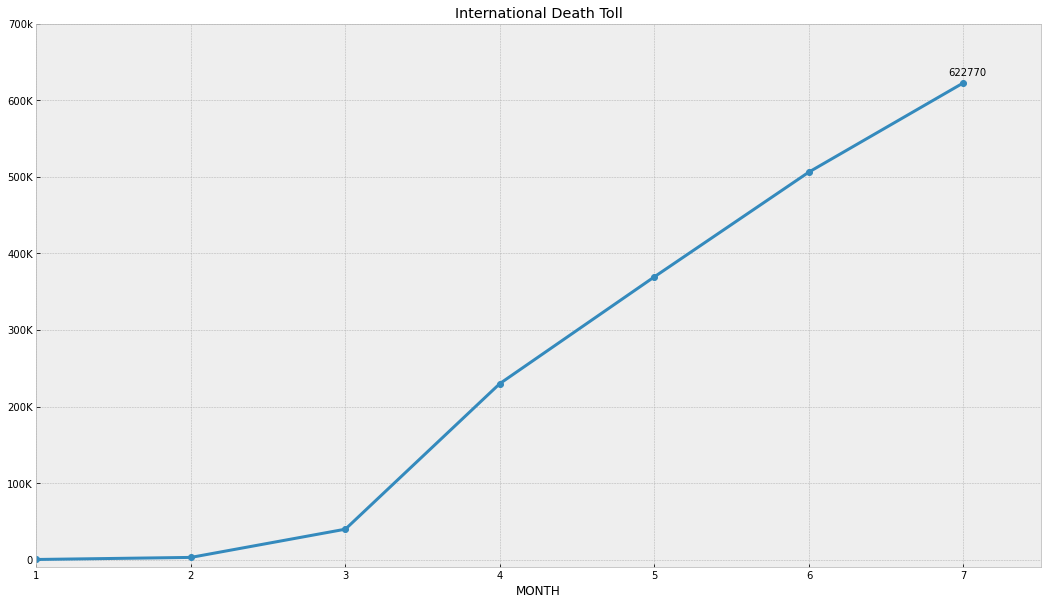

In [52]:
total_all['TOTAL_POSITIVE_CASE'].plot(linewidth=3, marker='o')
plt.title('All Positive Cases')

#setting up y-axis and x-axis of all positive cases
plt.xlim(1, 7.5)
plt.ylim(-100000, 16000000)
yticks = [0, 2000000, 4000000, 6000000, 8000000, 10000000, 12000000, 14000000, 16000000]
ylabels = ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M']
plt.yticks(ticks=yticks, labels=ylabels)
y = total_all['TOTAL_POSITIVE_CASE'].max()
plt.text(6.85, y+200000, str(y))
plt.show()

#setting up y-axis and x-axis of death toll
total_all['TOTAL_DEATH'].plot(linewidth=3, marker='o')
yticks = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000]
ylabels = ['0', '100K', '200K', '300K', '400K', '500K', '600K', '700k']
plt.yticks(ticks=yticks, labels=ylabels)
plt.xlim(1, 7.5)
plt.ylim(-10000, 700000)
y = total_all['TOTAL_DEATH'].max()
plt.text(6.9, y+10000, str(y))
plt.title('International Death Toll')
plt.show()